In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cProfile
import pstats
import io
import os
import h5py

In [18]:
def save_simulation_data_hdf5(filename, steps, lattices, energies, magnetizations, overwrite=False):
    with h5py.File(filename, 'a') as f:  # Open file in append or overwrite mode
        # If overwrite is True, delete existing datasets 
        if overwrite:
            for name in ['steps', 'energies', 'magnetizations']:
                if name in f:
                    del f[name]  # Delete existing dataset
            if 'lattices' in f:
                del f['lattices']  # Delete the entire group of lattices

        # Re-create datasets or append to them
        for name, data in [('steps', steps), ('energies', energies), ('magnetizations', magnetizations)]:
            if name not in f:
                # Create new dataset
                f.create_dataset(name, data=np.array(data), maxshape=(None,), compression="gzip", compression_opts=9)
            else:
                # Append data to existing dataset
                dset = f[name]
                original_size = dset.shape[0]
                dset.resize((original_size + len(data),))
                dset[original_size:] = data  # Append new data

        # Handle lattices, creating a new group if starting fresh or appending to it
        lattice_group = f.require_group('lattices')
        for i, step in enumerate(steps):
            lattice_key = f'lattice_{step}'
            # Create or overwrite lattice dataset for each step
            if overwrite and lattice_key in lattice_group:
                del lattice_group[lattice_key]  # Remove existing dataset if overwrite is True
            lattice_group.create_dataset(lattice_key, data=lattices[i], compression="gzip", compression_opts=9)

def load_selected_simulation_data_hdf5(filename, steps_to_load=None):
    try:
        with h5py.File(filename, 'r') as f:
            # Initialize
            loaded_steps = []
            energies = []
            magnetizations = []
            lattices = []

            if 'steps' not in f:
                raise ValueError("The HDF5 file does not contain 'steps' dataset.")

            steps_dataset = f['steps']
            all_steps = steps_dataset[:]
            
            # Determine indices for the steps to load
            if steps_to_load is not None:
                indices_to_load = [i for i, step in enumerate(all_steps) if step in steps_to_load]
            else:
                indices_to_load = range(len(all_steps))
            
            for idx in indices_to_load:
                step = all_steps[idx]
                loaded_steps.append(step)
                
                # Load energy and magnetization for the current step
                energies.append(f['energies'][idx])
                magnetizations.append(f['magnetizations'][idx])
                
                # Load lattice for the current step
                lattice_key = f'lattice_{step}'
                if lattice_key in f['lattices']:
                    lattices.append(f['lattices'][lattice_key][:])
                else:
                    lattices.append(None)

            return np.array(loaded_steps), lattices, np.array(energies), np.array(magnetizations)

    except FileNotFoundError:
        print(f"File {filename} not found. Starting a new simulation.")
        return None, None, None, None


def calculate_magnetization(lattice):
    M = np.sum(lattice)
    return M / np.size(lattice)

def calculate_specific_heat(energies, kB, T, N, dimensions):
    avg_energy = np.mean(energies)
    energy_sq = np.mean(np.array(energies)**2)
    C = (energy_sq - avg_energy**2) / (kB * T**2 * N**dimensions)  # Specific heat
    return C

def initialize_lattice(N, dimensions, q, model_type='ising'):
    size = tuple(N for _ in range(dimensions))
    # Determine spin states based on the model type
    if model_type == 'ising':
        spin_states = [-1, 1]
    elif model_type == 'potts':
        spin_states = np.arange(q)
    else:
        raise ValueError("Unsupported model type. Please choose 'ising' or 'potts'.")
    
    lattice = np.random.choice(spin_states, size=size)
    
    return lattice

def calculate_energy(lattice, J, model_type='ising'):
    """Calculate the total energy of the lattice."""
    dimensions = len(lattice.shape)
    energy = 0

    if model_type == 'ising':
        for dim in range(dimensions):
            shift = np.roll(lattice, shift=-1, axis=dim)
            energy += -J * np.sum(lattice * shift)

    elif model_type == 'potts':
        # standard Potts model
        for dim in range(dimensions):
            forward_shift = np.roll(lattice, shift=-1, axis=dim)
            matches = np.sum(lattice == forward_shift)
            energy += -J * matches

    return energy

def calculate_delta_energy_ising(site_index, lattice, J):
    """Calculate the energy difference for a proposed spin flip in the Ising model."""
    dims = lattice.shape
    energy_before = 0
    energy_after = 0
    spin = lattice[site_index]
    proposed_spin = -spin  # Flip spin

    # Iterate over each dimension to consider nearest neighbors
    for dim in range(len(dims)):
        for shift in [-1, 1]:  # Look at the neighbor in both directions along each dimension
            neighbor_index = list(site_index)
            neighbor_index[dim] = (neighbor_index[dim] + shift) % dims[dim]  # Periodic boundary conditions
            neighbor_spin = lattice[tuple(neighbor_index)]
            energy_before -= J * spin * neighbor_spin
            energy_after -= J * proposed_spin * neighbor_spin

    return energy_after - energy_before

def calculate_delta_energy_potts(site_index, lattice, J, q):
    """Calculate the energy difference for a proposed spin change in the Potts model."""
    dims = lattice.shape
    spin = lattice[site_index]
    possible_spins = [x for x in range(q) if x != spin]
    proposed_spin = np.random.choice(possible_spins)

    deltaE = 0
    # Iterate over each dimension to consider nearest neighbors
    for dim in range(len(dims)):
        for shift in [-1, 1]:  # Look at the neighbor in both directions along each dimension
            neighbor_index = list(site_index)
            neighbor_index[dim] = (neighbor_index[dim] + shift) % dims[dim]  # Periodic boundary conditions
            neighbor_spin = lattice[tuple(neighbor_index)]
            # Only count matches, as non-matches don't contribute to energy in Potts model
            if spin == neighbor_spin:
                deltaE += J  # Losing a match
            if proposed_spin == neighbor_spin:
                deltaE -= J  # Gaining a match

    return deltaE

def metropolis_step(lattice, J, kB, T, q, model_type='ising', current_energy=None):
    dims = lattice.shape
    total_sites = np.prod(dims)
    site_index = np.unravel_index(np.random.randint(total_sites), dims)
    spin = lattice[site_index]

    if model_type == 'ising':
        deltaE = calculate_delta_energy_ising(site_index, lattice, J)
    else:
        deltaE = calculate_delta_energy_potts(site_index, lattice, J, q)

    # Update proposal
    if deltaE < 0 or np.random.rand() < np.exp(-deltaE / (kB * T)):
        proposed_spin = -spin if model_type == 'ising' else np.random.choice([x for x in range(q) if x != spin])
        lattice[site_index] = proposed_spin
        if current_energy is not None:
            current_energy += deltaE

    return deltaE, current_energy

def run_simulation(N, dimensions, T, kB, J, q, model_type='ising', steps=10000, save_interval=100, chunk_size=100, simulation_state_file='simulation_state.npz'):
    T +=(10**-6)
    lattice = initialize_lattice(N, dimensions, q, model_type)
    current_energy = calculate_energy(lattice, J, model_type)

    # Initialize 
    accumulated_steps = []
    accumulated_lattices = []
    accumulated_energies = []
    accumulated_magnetizations = []

    for step in range(1,steps+1):
        deltaE, current_energy = metropolis_step(lattice, J, kB, T, q, model_type, current_energy)

        if step % save_interval == 0 or step == steps:
            accumulated_steps.append(step)
            accumulated_lattices.append(lattice.copy())
            accumulated_energies.append(current_energy)
            accumulated_magnetizations.append(calculate_magnetization(lattice))

            # Check if it's time to write the chunk
            if len(accumulated_steps) == chunk_size or step == steps:
                save_simulation_data_hdf5(simulation_state_file, accumulated_steps, accumulated_lattices, accumulated_energies, accumulated_magnetizations, overwrite=False)
                print(step)
                # Clear accumulated data after saving
                accumulated_steps = []
                accumulated_lattices = []
                accumulated_energies = []
                accumulated_magnetizations = []

    return True
########################################################################################

# Example usage
N = 32  # (atoms = N^d)
dim = 3
T = 2.28
kB = 1.0
J = 1.0 
q = 2  # spins
model_type = 'ising'  # 'ising' or 'potts'
steps = 10*q*N**dim*2#10000
print(steps)

success = run_simulation(N, dim, T, kB, J, q, model_type, steps, save_interval=1000, chunk_size=100, simulation_state_file='test.hdf5')
print(success)



1310720
True


In [7]:
profiler = cProfile.Profile()
profiler.enable()
for i in range(10):
    lattice, energies, magnetizations, C, M = run_simulation(N, dim, T, kB, J, q, model_type, steps)
profiler.disable()
#profiler.print_stats(sort='time')

# Create a BytesIO stream to capture the profiling data
s = io.StringIO()
# Create a Stats object from the profiler and sort the results by 'cumulative' time spent
ps = pstats.Stats(profiler, stream=s).sort_stats('cumulative')
# Print the stats to the StringIO stream
ps.print_stats(10)
# Now you can print the result from the StringIO object
print(s.getvalue())

         2374120 function calls in 5.639 seconds

   Ordered by: cumulative time
   List reduced from 58 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    5.640    2.820 /home/mishra94/.conda/envs/2022.10-py39/crit-phen/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3490(run_code)
        2    0.000    0.000    5.640    2.820 {built-in method builtins.exec}
       10    0.144    0.014    5.639    0.564 /tmp/ipykernel_510117/3401803351.py:141(run_simulation)
   100000    0.566    0.000    4.104    0.000 /tmp/ipykernel_510117/3401803351.py:121(metropolis_step)
   100000    2.322    0.000    2.335    0.000 /tmp/ipykernel_510117/3401803351.py:80(calculate_delta_energy_ising)
   200050    0.279    0.000    1.658    0.000 /home/mishra94/.conda/envs/2022.10-py39/crit-phen/lib/python3.10/site-packages/numpy/core/fromnumeric.py:71(_wrapreduction)
   100000    0.164    0.000    1.370    0.000 /tmp/

In [26]:
def plot_MC_steps(x,y,x_label,y_label,plot_filename=None):
    plt.scatter(x,y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if plot_filename:
        plt.save(plot_filename,dpi=600)
    else:
        plt.show()
    return None

In [23]:
filename = 'test.hdf5'
steps, lattices, energies, magnetizations = load_selected_simulation_data_hdf5(filename)

print(len(steps))
print(len(lattices))
print(steps)

1311
1311
[   1000    2000    3000 ... 1309000 1310000 1310720]


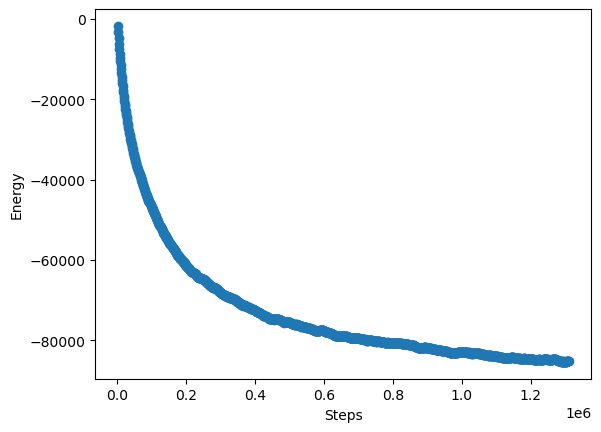

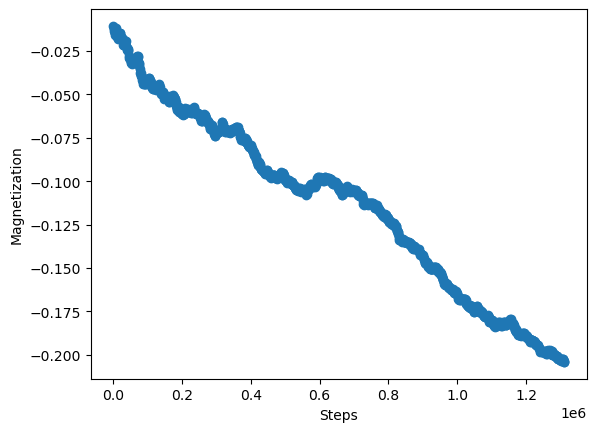

In [28]:
plot_MC_steps(steps,energies,'Steps', 'Energy')
plot_MC_steps(steps,magnetizations,'Steps', 'Magnetization')

In [23]:
N = 32  # (atoms = N^d)
dim = 3
T = 1.0
kB = 1.0
J = 1.0 
q = 2  # spins
model_type = 'ising'  # 'ising' or 'potts'
steps = 10*q*N**dim*2
print(steps)

1310720


In [19]:
temps = np.arange(0.1,4,0.1)
results = np.zeros((len(temps),2))

for i in range(len(temps)):
    T = temps[i]
    lattice, energies, magnetizations, C, M = run_simulation(N, dim, T, kB, J, q, model_type, steps)
    results[i,0] = C
    results[i,1] = M


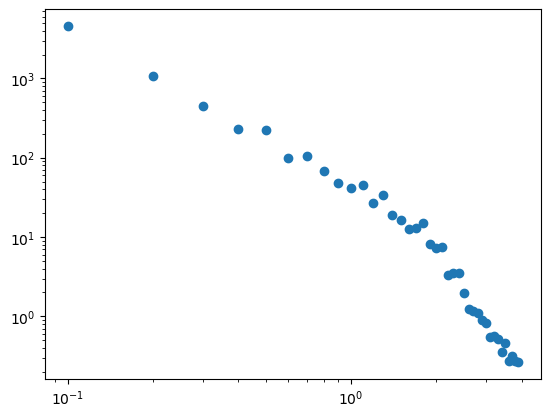

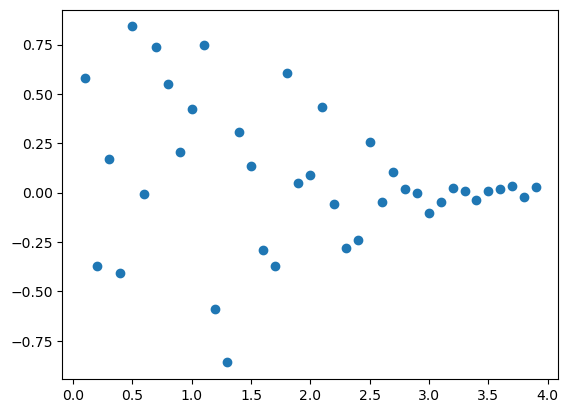

In [20]:

plt.scatter(temps,results[:,0])
plt.xscale('log')
plt.yscale('log')
plt.show()
plt.scatter(temps,results[:,1])
plt.xscale('linear')
plt.yscale('linear')
plt.show()